Name:Suah Siang Yu
Student No:P2342546
Class:DAAA/FT/2A/03


# Background Research

OpenAI Gym's Pendulum environment is a classic benchmark in the field of reinforcement learning (RL). It provides a useful testbed for developing and evaluating RL algorithms. Here's an overview of the key aspects related to this environment:

Environment Overview
Objective: The goal of the Pendulum environment is to balance a pendulum upright. The pendulum starts from a random initial angle and velocity, and the objective is to keep it balanced as long as possible by applying torques.

State Space: The state space consists of three continuous variables:

cos(θ): The cosine of the pendulum angle.
sin(θ): The sine of the pendulum angle.
θ_dot: The angular velocity of the pendulum.
Here, θ is the angle of the pendulum with respect to the vertical, and θ_dot is the rate at which this angle changes.

Action Space: The action space is continuous and represents the torque applied to the pendulum. This torque can be positive or negative, affecting the pendulum's motion.

Rewards: The reward function is designed to encourage the pendulum to stay upright. It is typically formulated as:

r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)

where $theta$ is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position). Based on the above equation, the minimum reward that can be obtained is -(pi2 + 0.1 * 82 + 0.001 * 22) = -16.2736044, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

# Deep Q-Networks (DQN)
Deep Q-Networks (DQN) represent a significant advancement in reinforcement learning, combining Q-Learning with deep neural networks. This method was popularized by a landmark paper from DeepMind in 2013, where it achieved impressive results on a range of Atari 2600 games.

Background
Q-Learning: The foundational idea of Q-Learning is to learn the optimal action-value function, 
𝑄∗(𝑠,𝑎), which estimates the expected reward for taking action 𝑎 in state 𝑠 and following the optimal policy thereafter. The Q-Learning algorithm updates the Q-values based on the Bellman equation:

𝑄(𝑠,𝑎)←𝑄(𝑠,𝑎)+𝛼[𝑟+𝛾max⁡𝑎′𝑄(𝑠′,𝑎′)−𝑄(𝑠,𝑎)]Q(s,a)←Q(s,a)+α[r+γ a ′max​ Q(s ′ ,a ′ )−Q(s,a)]
where:

𝛼 is the learning rate.
𝑟 is the reward received.
𝛾 is the discount factor.
𝑠′ is the next state.
𝑎′ represents possible actions in the next state.
Challenge: In environments with large or continuous state spaces, storing and updating a Q-table (which holds Q-values for every state-action pair) becomes impractical due to memory and computational constraints.

# Role of Discretization in DQN
DQN extends Q-Learning by using a deep neural network to approximate the Q-function. The network predicts Q-values for all possible actions given a state, allowing the algorithm to handle larger state spaces.
However, for the DQN framework to work effectively, the action space must be discrete because the Q-network outputs a Q-value for each possible action.
Why Discretization is Needed:

Network Output:

In DQN, the neural network outputs a Q-value for each discrete action. The network's architecture is designed to handle this discrete action space, making it straightforward to select the action with the highest Q-value.
If the action space were continuous, the network would need to handle an infinite number of possible actions, which is impractical for direct Q-value estimation.
Action Selection:

With a discrete action space, DQN uses an 
𝜖
ϵ-greedy policy where actions are selected based on the Q-values predicted by the network. The discrete nature of actions simplifies the process of selecting the action with the highest Q-value or exploring other actions.
Experience Replay:

DQN utilizes an experience replay buffer, storing and sampling past experiences. In a discrete action space, each experience can be easily indexed and retrieved, as each action corresponds to a unique index in the Q-value table.

In [12]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import time
import matplotlib.pyplot as plt 


In [13]:
class DQN:
    def __init__(self,
                 state_size=4,
                 action_size=2,
                 gamma=1,
                 replay_memory_min=1000,
                 batch_size=32,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_decay=0.995,
                 UpdateTargetEveryThisEpisodes=1):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.replay_memory_min = replay_memory_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.update_target_model()
        self.TargetUpdateCounter = 0
        self.Optimiser = Adam()


    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam())
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def Train(self, EndOfEpisode):
        if len(self.memory) < self.replay_memory_min:
            print(f'DID NOT TRAIN..., replay memory = {len(self.memory)}')
            return

        TrainingData = random.sample(self.memory, self.batch_size)

        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.model(ListOfS))

        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.target_model(ListOfSNext)

        X, Y = [], []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext

            X.append(S)
            Y.append(Q)

        self.GTfit(X, Y)

        if EndOfEpisode:
            self.TargetUpdateCounter += 1

        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.update_target_model()
            self.TargetUpdateCounter = 0

    @tf.function
    def GTfit(self, X, Y):
        with tf.GradientTape() as tape:
            Predictions = self.model(tf.convert_to_tensor(X), training=True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.model.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.model.trainable_variables))
        
    def DecayEpsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def GetAction(self, State):
        Q = self.model(State.reshape(-1, State.shape[0]))
        if np.random.rand() < self.epsilon:
            Action = np.random.randint(self.action_size) #do a random action
        else:
            Action = np.argmax(Q) #get highest Q-value
        return Action
    



# Hyperparamemter (Epsilon)
## Exploration and Exploitation

<ul>
<li>Exploration: Initially, when epsilon (EpsilonStart) is high (e.g., 1.0), the agent takes more random actions. This exploration phase allows the agent to gather diverse experiences and learn about the environment. This randomness is crucial early on when the agent has little knowledge about the environment.</li>

<li>Exploitation: As episodes progress and epsilon decays (multiplying by 0.995 each time DecayEpsilon is called), the agent starts relying more on its learned policy (Main network) to select actions. This exploitation phase focuses on maximizing rewards based on the learned Q-values, thus refining its decision-making towards optimal actions.</li>
</ul>

Decay Rate (EpsilonDecay):
<ul>
<li>A decay rate of 0.995 means that epsilon decreases by 0.5% (or 1 - 0.995 = 0.005) after each episode. This slow decay rate ensures that exploration continues for a considerable number of episodes before transitioning into exploitation.</li>

<li>Slowing down the decay rate allows the agent to strike a balance between exploring new actions (to discover potentially better strategies) and exploiting known actions (to maximize immediate rewards). A slower decay also helps in stabilizing the learning process, preventing the agent from prematurely converging to suboptimal solutions.</li>
</ul>
Effect on Learning:
<ul>
<li>Early Learning: High epsilon encourages exploration, leading to a diverse set of experiences stored in the replay memory (ReplayMemory). This diversity helps in building a robust Q-function that accurately estimates Q-values.</li>

<li>Later Learning: As epsilon decreases, the agent shifts focus towards exploiting its learned Q-function. By gradually reducing exploration, the agent leverages accumulated knowledge to make more informed decisions, potentially improving its performance over time.</li>
</ul>

In [14]:

EnvName = 'Pendulum-v0'
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.995
ShowEvery = 10
state_size = 3
action_size = 40

def PendulumActionConverter(A, action_size=action_size):
    ActualTorque = (A / action_size - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(A, action_size=action_size):
    ActualA = round((A + 2) * (action_size - 1) / 4)
    return ActualA

def OneEpisode():
    env = gym.make(f'{EnvName}')
    S = env.reset()
    ListOfRewards = []
    Done = False

    while not Done:
        A = DQN.GetAction(S)
        AStep = np.array([PendulumActionConverter(A)])
        
        if episode % ShowEvery == 0 and len(DQN.memory) >= DQN.replay_memory_min:
            env.render()
        
        SNext, R, Done, Info = env.step(AStep)
        DQN.remember(S, A, R, SNext, Done)
        DQN.Train(Done)
        ListOfRewards.append(R)
        S = SNext
        DQN.DecayEpsilon()

    total_reward = np.sum(ListOfRewards)
    print(f'Finished! Return: {total_reward}')
    env.close()
    return total_reward  




The functions PendulumActionConverter and PendulumInverseActionConverter are designed to convert actions

Purpose:
This function converts a discrete action representation (e.g., an index) into a continuous torque value that can be used to control the pendulum.
Parameters:
A: This is the discrete action value or index. In a typical reinforcement learning setting, this could be an integer index corresponding to a specific action.
action_size: This represents the total number of discrete actions available. This parameter is used to normalize the action value.
Conversion Process:
Normalization: (A / action_size - 0.5)

A / action_size scales the action index A to a value between 0 and 1.
Subtracting 0.5 shifts this range to be centered around 0, resulting in a range from -0.5 to 0.5.
Scaling: * 4

Multiplying by 4 scales the range to be from -2 to 2. This is based on the assumption that the maximum and minimum torque values the pendulum can handle are -2 and 2, respectively.
Result:
The function converts a discrete action index into a continuous torque value that can be applied to the pendulum. This is useful for environments where actions need to be represented in continuous space.

In [15]:
STARTTIME = time.time()

# Create the DQN 
DQN = DQN(state_size=state_size, action_size=action_size, epsilon=epsilon,
                epsilon_min = epsilon_min, epsilon_decay = epsilon_decay)
# Variables to track performance
total_rewards = []
best_reward = -np.inf
model_save_path = "best_dqn_model.h5"


for episode in range(200):
    print(f'Episode {episode + 1}')
    total_reward = OneEpisode()
    total_rewards.append(total_reward)  # Record the total reward for this episode

    # Save the model if the current total reward is greater than the best reward
    if total_reward > best_reward:
        best_reward = total_reward
        DQN.model.save(model_save_path)  # Save the model
        print(f"New best model saved with reward: {best_reward}")


Episode 1
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


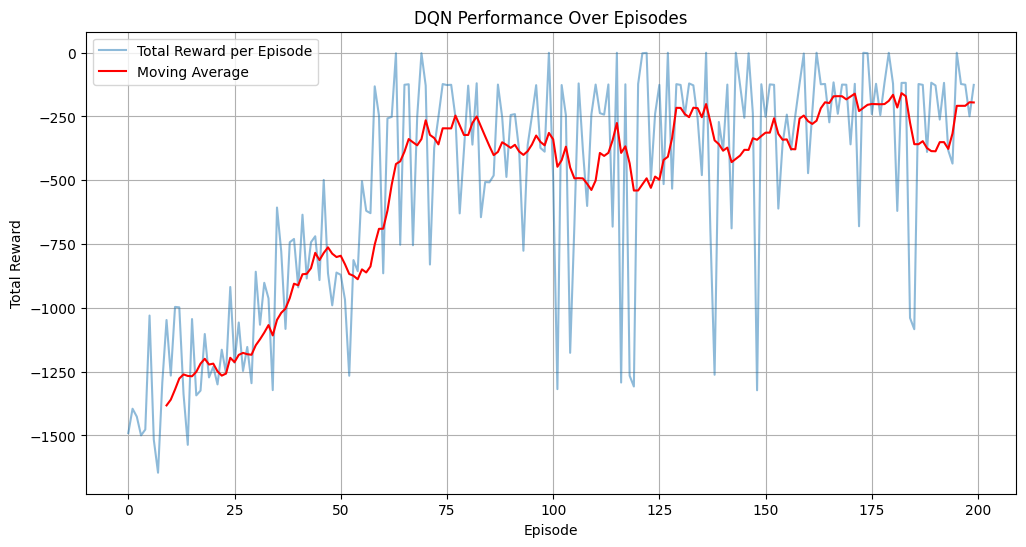

In [16]:
# Calculate moving average for smoother plotting
window_size = 10
moving_average = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(total_rewards, label='Total Reward per Episode', alpha=0.5)
plt.plot(range(window_size - 1, len(total_rewards)), moving_average, label='Moving Average', color='red')
plt.title('DQN Performance Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()
plt.show()



##### Insights
The total reward per episode shows a clear upward trend, but there are significant fluctuations in the early stages of training. These fluctuations are largely due to the epsilon-greedy exploration strategy. During this phase, the agent frequently explores different actions, leading to variable rewards. As epsilon decreases over time, the agent increasingly exploits known strategies, resulting in more stable rewards.

The moving average smooths out these fluctuations, revealing a more consistent improvement trend. We observe a rapid increase in performance between episodes 20 and 75, indicating effective learning. As the agent’s policy becomes more refined, the improvements start to flatten, suggesting that the agent is approaching its performance limit or maximum reward. Increasing the number of episodes would have no significant improvements on the DQN.

Overall, the fluctuations are a natural part of the learning process, while the moving average highlights the agent’s successful adaptation and learning progression.

